# Homework 3 Part 2 Task 3 - Cross-validation
This task is similar to task 2: you will build regressors to Predict House Prices <br>
Here is the difference: we will use cross-validation to find the best hyper-parameters <br>
If the dataset is relatively small, cross-validation may lead to a better estimation <br>
Since we are in the 'big-data' and 'cloud-data' era, a one-time trainig-validation-testing split is just fine. <br>
However, you should do this task in case that your future boss gives you a small dataset and wants some results. <br>

### Create your "signature"
Run the cell below but do NOT modify the cell. \
The signature needs to be displayed right below the cell in this file. \
You will get zero point if the signature is not displayed. 

In [1]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature=[socket.gethostbyname(socket.gethostname()),
           getpass.getuser(),
           datetime.now(),
           random.random()]
print(signature) 

['127.0.0.1', 'sloanatkins', datetime.datetime(2025, 11, 1, 21, 14, 23, 927019), 0.8657788435623314]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load the training and testing datasets
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [3]:
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")
data_test['SalePrice']=data_test_y['SalePrice']
data_train['train']=1
data_test['train']=0
data = pd.concat([data_train, data_test], axis=0, sort=False)
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


the regression target is SalePrice

In [5]:
data.head().SalePrice

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## Handle missing values (NaN and None)
show the missing values for each feature

In [6]:
#show the missing values in a table
Missing = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'],sort=False)
Missing[Missing.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4
LotFrontage,259,227
Alley,1369,1352
Utilities,0,2
Exterior1st,0,1
Exterior2nd,0,1
MasVnrType,872,894
MasVnrArea,8,15
BsmtQual,37,44
BsmtCond,37,45


<Axes: xlabel='None', ylabel='None'>

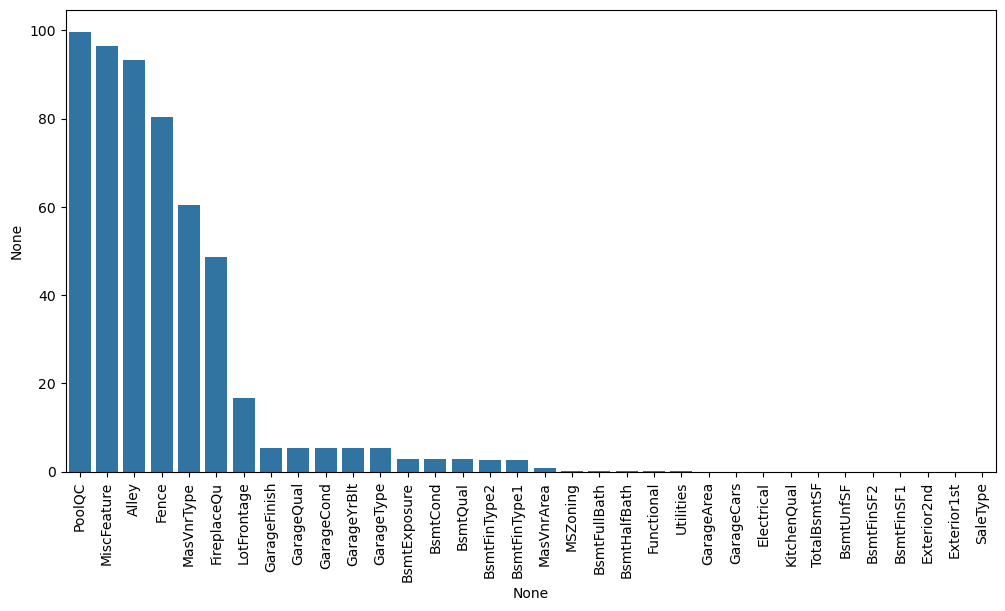

In [7]:
#show the missing values in a plot
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
sns.barplot(x=data_missing.index, y=data_missing)

From the figure, we see that nearly 100% values of the feature/column 'PoolQC' are missing <br>
We can simply delete these features (drop these columns from the table) of which >=50% values are missing

In [8]:
#note: you may get a different output due to version issues of Pandas, which is fine
feature_drop = data_missing[data_missing >=50].index
feature_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], dtype='object')

In [9]:
#drop the columns
data=data.drop(columns=feature_drop)
#drop Id
data=data.drop(columns='Id')

In [10]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


For those features with < 50% missing values, we can use impute method. <br>
Missing numerical values can be imputed with a constant value, or some statistics (mean, median or most frequent) of each column in which the missing values are located. <br>
Missing categorical/non-numeric values can be imputed with the most frequent category, or a new category-'nothing'

In [11]:
numerical_column=[]
categorical_column=[]
for c in data.columns:
    v=data[c]
    v=v[~v.isnull()]
    if data[c].dtype == np.dtype('O'): # non-numeric values       
        #data[c]=data[c].fillna(v.value_counts().index[0]) # the most frequent category
        data[c]=data[c].fillna('nothing') # a new category         
        categorical_column.append(c)
    else: # numeric 
        if c != 'train' and c != 'SalePrice':
            data[c]=data[c].fillna(v.median()) 
        numerical_column.append(c)        

check if there is any missing value

In [12]:
data[data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train


convert categorical values to numerical values using one-hot encoding <br>
note: there are other methods to encode categorical values

In [13]:
data=pd.get_dummies(data, columns=categorical_column)
data.shape

(2919, 291)

In [14]:
#the table has many new columns
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nothing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,True,False,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,True,False,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,True,False,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,True,False,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,True,False,False,False,False,False,True,False


### get training data and testing data from `data`

In [15]:
data_train = data[data['train']==1]
X_train=data_train.drop(columns=['SalePrice', 'train']).values
Y_train=data_train['SalePrice'].values

In [16]:
X_train.dtype

dtype('O')

In [17]:
X_train.shape

(1460, 289)

In [18]:
Y_train.dtype

dtype('float64')

In [19]:
data_test = data[data['train']==0]
X_test=data_test.drop(columns=['SalePrice', 'train']).values
Y_test=data_test['SalePrice'].values

### Train a regression model to predict SalePrice

Text(0.5, 1.0, 'histogram of SalePrice in training set')

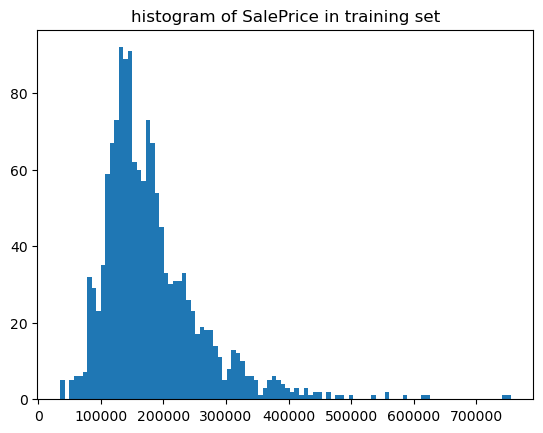

In [20]:
plt.hist(data_train.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in training set')

Text(0.5, 1.0, 'histogram of SalePrice in testing set')

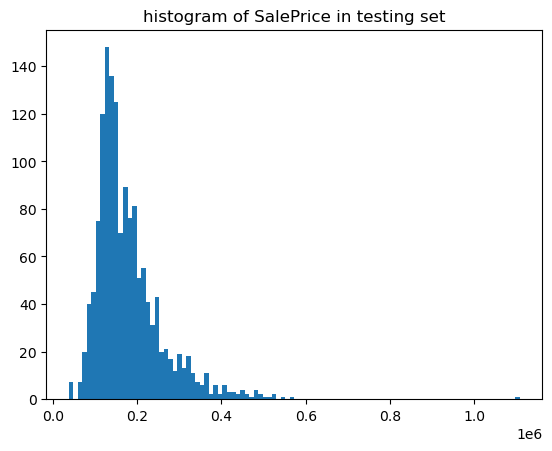

In [21]:
plt.hist(data_test.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in testing set')

### Predict SalePrice using a linear regression model

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

show the training result

(np.float64(0.0),
 np.float64(1000000.0),
 np.float64(0.0),
 np.float64(1000000.0))

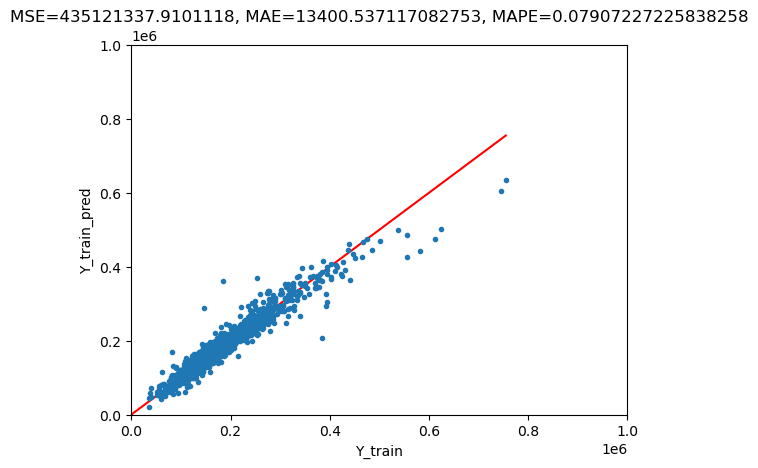

In [23]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(np.float64(0.0),
 np.float64(1000000.0),
 np.float64(0.0),
 np.float64(1000000.0))

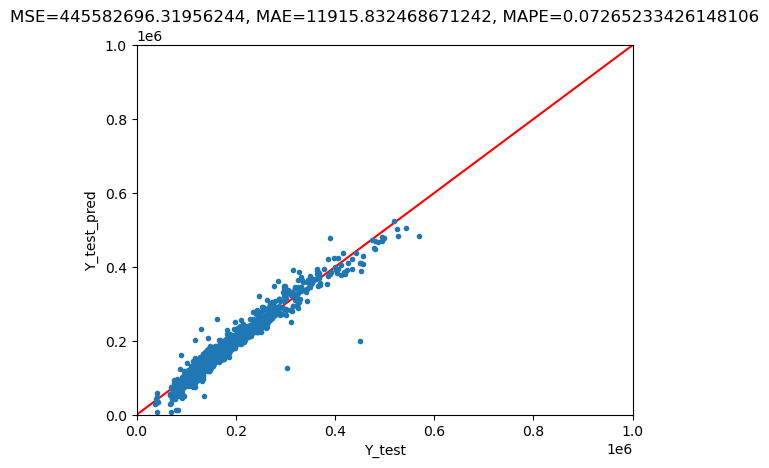

In [24]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [25]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

np.int64(319)

Perform 10-fold cross valiation to get the average MAPE (or other accuracy measurements)

In [26]:
#attention: if you choose to use GridSearchCV
#           it assumes a better model has a higher score
#           thus, my_scorer should return -MAPE as the score of the model
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    #MSE = np.mean((y_pred - y)**2)
    #MAE = np.mean(np.abs(y_pred - y))
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE
#
from sklearn.model_selection import cross_val_score
MAPE_array = cross_val_score(linear_model, X_train, Y_train, cv=10, scoring=my_scorer)
MAPE_array

array([0.1112827 , 0.10379275, 0.10861564, 0.12015531, 0.12089387,
       0.10543086, 0.10761207, 0.08897552, 0.12290176, 0.09407662])

Linear regression seems to be fine except for a few testing data points <br>
Next, let's try nonlinear regression models and see if we can get better results

## Your task begins here
### Predict SalePrice using nonlinear regression models
Try the two types of models <br>
(1) KNN (hyperparameter is `n_neighbors`) <br>
(2) random forest <br>
&nbsp;&nbsp;&nbsp; It has many hyperparameters. <br>
&nbsp;&nbsp;&nbsp; You can just focus on `max_depth` <br>
(3) xgboost <br>
&nbsp;&nbsp;&nbsp; It has many hyperparameters. <br>
&nbsp;&nbsp;&nbsp; You can just focus on `max_depth` <br>

For model selection (i.e. to determine the hyperparameters), we apply cross-validation to get the average MAPE (or other measurements) on the validation sets. Try different sets of hyperparameters, and find the best hyperparameters associated with the minimum average MAPE. <br>
A simple strategy is grid search, which you will use to find the optimal hyperparameters. <br>
You may use the function `GridSearchCV` in https://scikit-learn.org/stable/modules/grid_search.html <br>
or write a for loop to do grid search, like this 
```python
MAPE_average_list=[]
hyperparameter_list=[1, 2, 3, 4, 5]
for hyperparameter in hyperparameter_list:
    my_model=SomeRegressor(hyperparameter) # set random_state=0 if possible
    MAPE_array = cross_val_score(my_model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
MAPE_average_list=np.array(MAPE_average_list)
#hyperparameter_best = hyperparameter_list[np.argmin(MAPE_average_list)]
#or hyperparameter_best is the point at which the curve hyperparameter~MAPE becomes flat 
plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('hyperparameter')
plt.ylabel('MAPE')  
```    
`cross_val_score` is imported from sk-learn <br>
note: set 'n_jobs=4' to use multiple (4) cpu cores <br>
After the best hyperparameter is found, fit the model (using the best hyperparameter) to the whole training set, <br> 
and evaluate the model on the testing set (`X_test`, `Y_test`) to get MSE, MAE and MAPE  <br>
Do not use MSE/MAE/MAPE on the testing set for tuning hyperparameters, which will be 'cheating' <br>

Plot `hyperparameter` vs `MAPE` <br>
Plot `Y_train` vs `Y_train_pred`  <br>
Plot `Y_test` vs `Y_test_pred`  <br>
Show the values of MSE, MAE and MAPE on the traning set and the testing set <br>

#### KNeighborsRegressor

In [27]:
from sklearn.neighbors import KNeighborsRegressor
#use a for loop to do 10-fold cross-valiation to find the best n_neighbors
from sklearn.model_selection import cross_val_score
import numpy as np

def my_scorer(model, X, y):
    y_pred = model.predict(X)
    MAPE = np.mean(np.abs(y_pred - y) / y)
    return MAPE

n_neighbors_list = np.arange(1, 21, 1)
MAPE_average_list = []

for k in n_neighbors_list:
    knn = KNeighborsRegressor(n_neighbors=k)
    MAPE_array = cross_val_score(knn, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())

MAPE_average_list = np.array(MAPE_average_list)


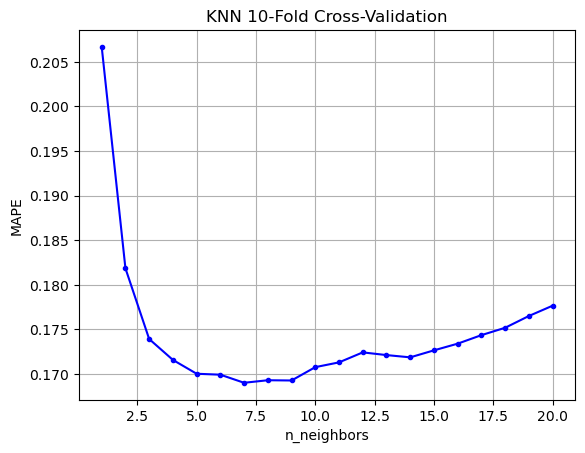

Best n_neighbors = 7


In [28]:
#plot and find the best n_neighbors
import matplotlib.pyplot as plt

plt.plot(n_neighbors_list, MAPE_average_list, '.-b')
plt.xlabel('n_neighbors')
plt.ylabel('MAPE')
plt.title('KNN 10-Fold Cross-Validation')
plt.grid(True)
plt.show()

best_index = np.argmin(MAPE_average_list)
n_neighbors_best = n_neighbors_list[best_index]
print("Best n_neighbors =", n_neighbors_best)


build a KNeighborsRegressor using the best hyperparameter <br>
fit it to the training data and test it on the testing data

In [29]:
knn_best = KNeighborsRegressor(n_neighbors=n_neighbors_best)
knn_best.fit(X_train, Y_train)

Y_train_pred = knn_best.predict(X_train)
Y_test_pred = knn_best.predict(X_test)

show the training result

In [30]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE = np.mean(np.abs(Y_train - Y_train_pred) / Y_train)

print("Evaluate model on training set")
print("MSE =", MSE)
print("MAE =", MAE)
print("MAPE =", MAPE)

print("\nEvaluate model on testing set")
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE = np.mean(np.abs(Y_test - Y_test_pred) / Y_test)

print("MSE =", MSE)
print("MAE =", MAE)
print("MAPE =", MAPE)


Evaluate model on training set
MSE = 1573480679.5853229
MAE = 24739.97299412916
MAPE = 0.14366371327647984

Evaluate model on testing set
MSE = 2010223312.7858474
MAE = 26345.20752791379
MAPE = 0.15305632825601678


show the testing result

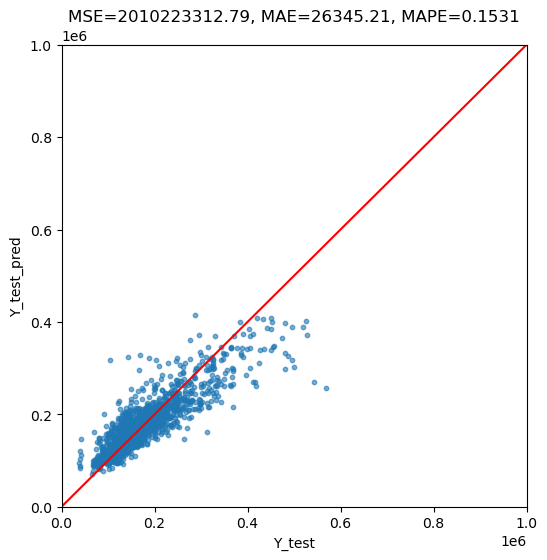

In [31]:
import matplotlib.pyplot as plt
import numpy as np

MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE = np.mean(np.abs(Y_test - Y_test_pred) / Y_test)

plt.figure(figsize=(6, 6))
plt.scatter(Y_test, Y_test_pred, s=10, alpha=0.6)
plt.plot([0, 1e6], [0, 1e6], '-r')  
plt.xlabel("Y_test")
plt.ylabel("Y_test_pred")
plt.title(f"MSE={MSE:.2f}, MAE={MAE:.2f}, MAPE={MAPE:.4f}")
plt.axis([0, 1e6, 0, 1e6])
plt.show()


#### RandomForestRegressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# use a for loop to do 10-fold cross-validation to find the best max_depth
max_depth_list = np.arange(1, 101, 2)  
MAPE_average_list = []

for d in max_depth_list:
    model = RandomForestRegressor(
        n_estimators=20,
        max_depth=d,
        random_state=0,
        n_jobs=4
    )
    MAPE_array = cross_val_score(model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())

MAPE_average_list = np.array(MAPE_average_list)


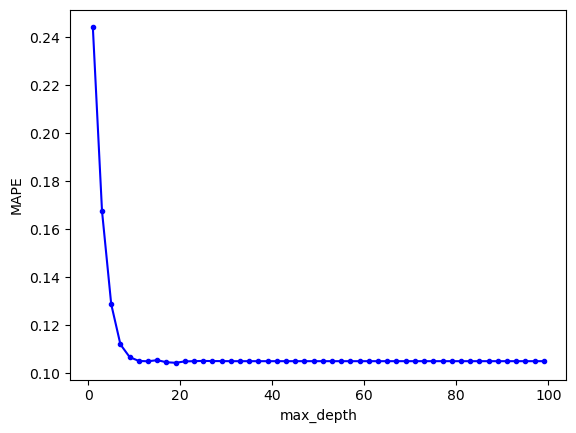

Best max_depth = 19


In [35]:
#plot and find the best max_depth
import matplotlib.pyplot as plt

plt.plot(max_depth_list, MAPE_average_list, '.-b')
plt.xlabel('max_depth')
plt.ylabel('MAPE')
plt.show()

max_depth_best = max_depth_list[np.argmin(MAPE_average_list)]
print("Best max_depth =", max_depth_best)


build a RandomForestRegressor using the best hyperparameter <br> 
fit it to the training data and test it on the testing data

In [36]:
RF_best = RandomForestRegressor(
    n_estimators=20,
    max_depth=max_depth_best,  
    random_state=0,
    n_jobs=4
)

RF_best.fit(X_train, Y_train)

Y_train_pred = RF_best.predict(X_train)
Y_test_pred  = RF_best.predict(X_test)

show the training result

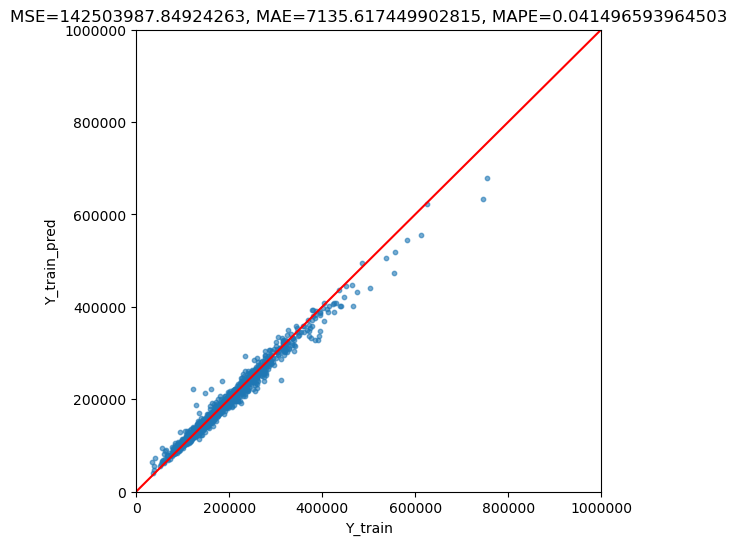

Exception ignored in: <function ResourceTracker.__del__ at 0x1069ddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102fbdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105271bc0>
Traceback (most recent call last

In [ ]:
# show the training result

import matplotlib.pyplot as plt
import numpy as np

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE = np.mean(np.abs(Y_train - Y_train_pred) / Y_train)

plt.figure(figsize=(6,6))
plt.plot([0, 1000000], [0, 1000000], '-r') 
plt.scatter(Y_train, Y_train_pred, s=10, alpha=0.6)
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')

plt.ticklabel_format(style='plain')

plt.axis([0, 1000000, 0, 1000000])
plt.title(f"MSE={MSE}, MAE={MAE}, MAPE={MAPE}")
plt.show()


show the testing result

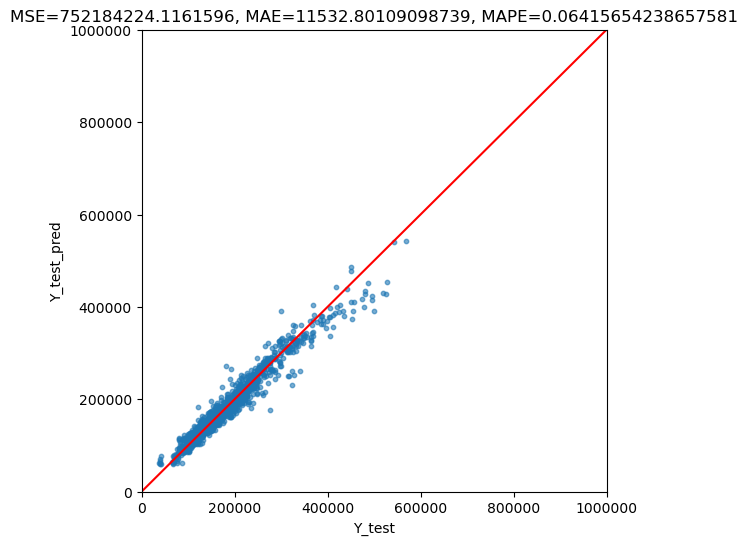

In [43]:

import matplotlib.pyplot as plt
import numpy as np

MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE = np.mean(np.abs(Y_test - Y_test_pred) / Y_test)

plt.figure(figsize=(6,6))
plt.plot([0, 1000000], [0, 1000000], '-r') 
plt.scatter(Y_test, Y_test_pred, s=10, alpha=0.6)
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')

plt.ticklabel_format(style='plain')

plt.axis([0, 1000000, 0, 1000000])
plt.title(f"MSE={MSE}, MAE={MAE}, MAPE={MAPE}")
plt.show()


#### XGBRegressor
https://anaconda.org/anaconda/py-xgboost

In [68]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Define parameter range for max_depth
max_depth_list = np.arange(1, 41, 2)
MAPE_average_list = []

# 2. Define scorer (return negative MAPE so GridSearchCV logic is correct)
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    return -np.mean(np.abs(y_pred - y) / y)

# 3. Perform 10-fold cross-validation for each max_depth
for d in max_depth_list:
    model = XGBRegressor(
        n_estimators=20,
        max_depth=d,
        random_state=0,
        objective='reg:squarederror'
    )
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=1)
    MAPE_average_list.append(-scores.mean())      # flip sign to get positive MAPE

MAPE_average_list = np.array(MAPE_average_list)
max_depth_best = max_depth_list[np.argmin(MAPE_average_list)]
print("Best max_depth:", max_depth_best)
print("MAPE values:", MAPE_average_list.round(6))


Best max_depth: 5
MAPE values: [0.145697 0.108361 0.098976 0.101832 0.105789 0.110737 0.110025 0.111556
 0.11092  0.112247 0.111225 0.111187 0.111321 0.111205 0.111221 0.1112
 0.1112   0.1112   0.1112   0.1112  ]


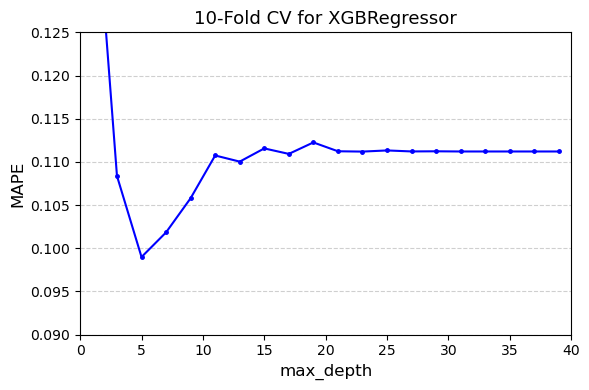

In [69]:
plt.figure(figsize=(6,4))
plt.plot(max_depth_list, MAPE_average_list, 'b.-', linewidth=1.5, markersize=5)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('MAPE', fontsize=12)
plt.title('10-Fold CV for XGBRegressor', fontsize=13)
plt.xlim(0, 40)
plt.ylim(0.09, 0.125)
plt.xticks(np.arange(0, 41, 5))
plt.yticks(np.arange(0.09, 0.126, 0.005))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


build a XGBRegressor using the best hyperparameter and fit it to the training data

In [70]:
XGBR = XGBRegressor(
    n_estimators=20,
    max_depth=max_depth_best,
    random_state=0,
    objective='reg:squarederror'
)
XGBR.fit(X_train, Y_train)
Y_train_pred = XGBR.predict(X_train)
Y_test_pred  = XGBR.predict(X_test)


show the training result

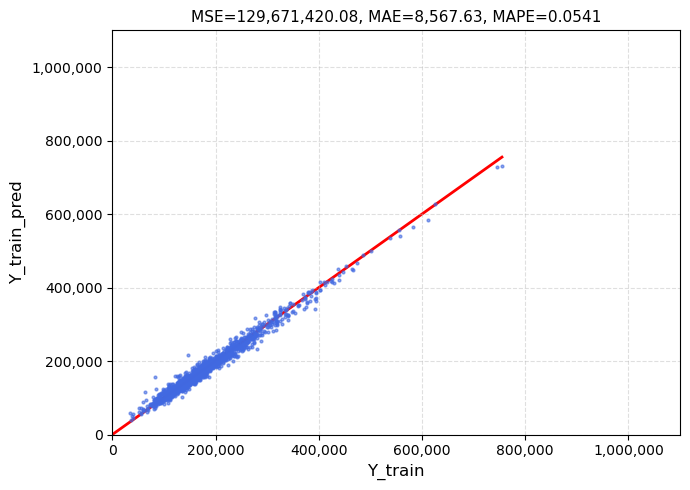

In [73]:
import matplotlib.ticker as mticker

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE = np.mean(np.abs(Y_train - Y_train_pred) / Y_train)

plt.figure(figsize=(7,5))
plt.plot(Y_train, Y_train_pred, '.', color='royalblue', alpha=0.6, markersize=4)
ymax = max(Y_train.max(), Y_train_pred.max())
plt.plot([0, ymax], [0, ymax], color='red', linewidth=2, zorder=0)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xlim(0, 1_100_000)
plt.ylim(0, 1_100_000)
plt.xlabel("Y_train", fontsize=12)
plt.ylabel("Y_train_pred", fontsize=12)
plt.title(f"MSE={MSE:,.2f}, MAE={MAE:,.2f}, MAPE={MAPE:.4f}", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


show the testing result

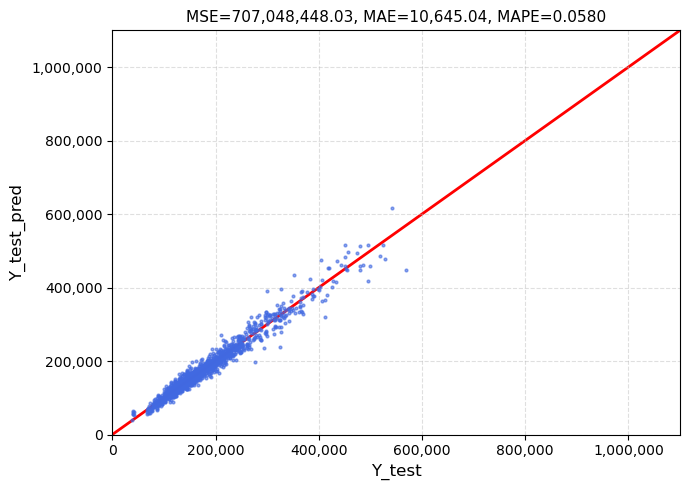

In [74]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE = np.mean(np.abs(Y_test - Y_test_pred) / Y_test)

plt.figure(figsize=(7,5))
plt.plot(Y_test, Y_test_pred, '.', color='royalblue', alpha=0.6, markersize=4)
ymax = max(Y_test.max(), Y_test_pred.max())
plt.plot([0, ymax], [0, ymax], color='red', linewidth=2, zorder=0)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xlim(0, 1_100_000)
plt.ylim(0, 1_100_000)
plt.xlabel("Y_test", fontsize=12)
plt.ylabel("Y_test_pred", fontsize=12)
plt.title(f"MSE={MSE:,.2f}, MAE={MAE:,.2f}, MAPE={MAPE:.4f}", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [75]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

np.int64(234)

In this task, linear model is as good as nonlinear models <br>